Using device: cuda
Loading datasets...
Loaded CelebA dataset with 10000 samples
Loaded Binary dataset with 144000 samples
Loaded LCC FASD real dataset with 1302 samples
Loaded LCC FASD spoof dataset with 7444 samples
Loaded CASIA-SURF train dataset with 29266 samples as test dataset
Creating data loaders...

Dataset Statistics:
Training samples: 130196
Validation samples: 32550
Test samples: 29266

Showing sample images:
Training Set:


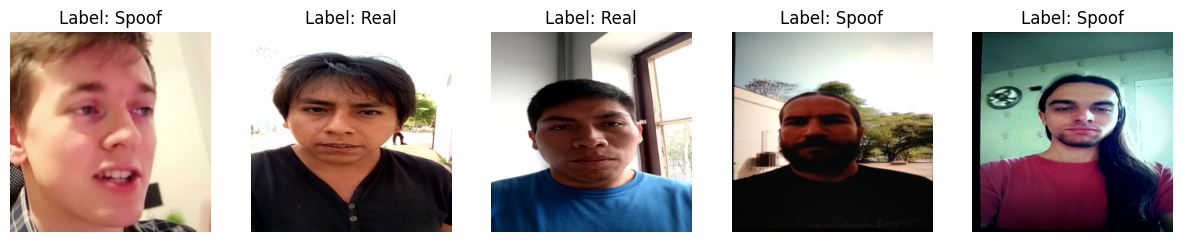

Validation Set:


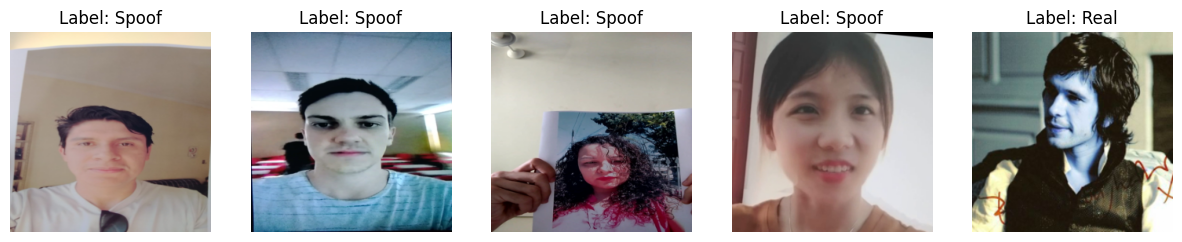

Test Set:


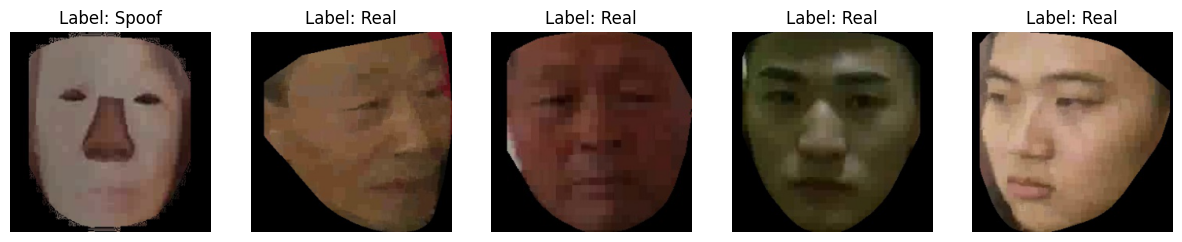

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, Subset, ConcatDataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image

# Define device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset Definitions

# Dataset One - CelebA Dataset from NPZ file
class CelebADataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data = np.load(data_path)
        self.X = self.data['arr_0']
        self.y = self.data['arr_1']
        self.transform = transform
        print(f"Loaded CelebA dataset with {len(self.y)} samples")

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]
        if self.transform:
            image = Image.fromarray(image)
            image = self.transform(image)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

# Dataset Two - Binary Dataset from Directories
class BinaryDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []

        for category in ["attack_cce", "attack_hp", "attack_print1", "attack_print2", "real"]:
            label = 0 if category.startswith("attack") else 1
            category_dir = os.path.join(root_dir, category)
            if os.path.exists(category_dir):
                for root, _, files in os.walk(category_dir):
                    for file in files:
                        if file.endswith((".jpg", ".png")):
                            self.data.append((os.path.join(root, file), label))
        
        print(f"Loaded Binary dataset with {len(self.data)} samples")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

# Dataset Three - LCC FASD Dataset
class SpoofDataset(Dataset):
    def __init__(self, root_dir, category, label, transform=None):
        self.root_dir = os.path.join(root_dir, category)
        self.transform = transform
        self.data = []
        self.label = label

        if os.path.exists(self.root_dir):
            for root, _, files in os.walk(self.root_dir):
                for file in files:
                    if file.endswith((".png", ".jpg")):
                        self.data.append(os.path.join(root, file))
        
        print(f"Loaded LCC FASD {category} dataset with {len(self.data)} samples")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(self.label, dtype=torch.long)

# Dataset Four - CASIA-SURF Dataset for Test
class CASIADataset(Dataset):
    def __init__(self, dataset_path, txt_file_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.samples = []

        # Read the txt file and collect paths for images along with their labels
        with open(txt_file_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 2:
                    color_path = parts[0]
                    label = int(parts[-1])
                    color_full_path = os.path.join(self.dataset_path, color_path)
                    if os.path.exists(color_full_path):
                        self.samples.append((color_full_path, label))

        print(f"Loaded CASIA-SURF train dataset with {len(self.samples)} samples as test dataset")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        color_path, label = self.samples[idx]
        image = Image.open(color_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

# Define the transforms
resize_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Load all datasets
def load_all_datasets():
    # Load the CelebA dataset
    celebA_dataset = CelebADataset('anti_spoofing_data_224.npz', transform=resize_transform)

    # Load the Binary dataset
    binary_dataset = BinaryDataset(
        "/media/pria/New Volume/Spoofing/Datasets/2020-plosone-recod-mpad/",
        transform=resize_transform
    )

    # Load the LCC FASD dataset (real and spoof)
    lcc_fasd_real = SpoofDataset(
        root_dir="/media/pria/New Volume/Spoofing/Datasets/LCC_FASD_CASIA/lcc-fasd-casia/LCC_FASD/LCC_FASD_training",
        category="real",
        label=1,
        transform=resize_transform
    )
    lcc_fasd_spoof = SpoofDataset(
        root_dir="/media/pria/New Volume/Spoofing/Datasets/LCC_FASD_CASIA/lcc-fasd-casia/LCC_FASD/LCC_FASD_training",
        category="spoof",
        label=0,
        transform=resize_transform
    )

    # Load CASIA-SURF train dataset as the test dataset
    casia_dataset = CASIADataset(
        dataset_path="/media/pria/New Volume/Spoofing/Datasets/CASIA-SURF-Challenge/",
        txt_file_path="/media/pria/New Volume/Spoofing/Datasets/CASIA-SURF-Challenge/train_list.txt",
        transform=resize_transform
    )

    return celebA_dataset, binary_dataset, lcc_fasd_real, lcc_fasd_spoof, casia_dataset

def create_data_loaders(celebA_dataset, binary_dataset, lcc_fasd_real, lcc_fasd_spoof, casia_dataset):
    # Combine training datasets
    combined_train_dataset = ConcatDataset([celebA_dataset, binary_dataset, lcc_fasd_real, lcc_fasd_spoof])

    # Split into training and validation sets
    train_indices, val_indices = train_test_split(
        list(range(len(combined_train_dataset))),
        test_size=0.2,
        random_state=42
    )

    # Create subsets
    train_dataset = Subset(combined_train_dataset, train_indices)
    val_dataset = Subset(combined_train_dataset, val_indices)

    # Create DataLoaders with shuffle=True
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(casia_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader

# Displaying sample images
def show_images(dataloader, num_images=5):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    
    images = images[:num_images]
    labels = labels[:num_images]
    
    fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
    for idx, (img, label) in enumerate(zip(images, labels)):
        img = img.permute(1, 2, 0).cpu().numpy()
        axes[idx].imshow(img)
        axes[idx].set_title(f"Label: {'Real' if label.item() == 1 else 'Spoof'}")
        axes[idx].axis('off')
    plt.show()

# Load datasets and create data loaders
print("Loading datasets...")
celebA_dataset, binary_dataset, lcc_fasd_real, lcc_fasd_spoof, casia_dataset = load_all_datasets()

print("Creating data loaders...")
train_loader, val_loader, test_loader = create_data_loaders(
    celebA_dataset, binary_dataset, lcc_fasd_real, lcc_fasd_spoof, casia_dataset
)

# Show dataset statistics and sample images
print("\nDataset Statistics:")
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

# Display sample images
print("\nShowing sample images:")
print("Training Set:")
show_images(train_loader)
print("Validation Set:")
show_images(val_loader)
print("Test Set:")
show_images(test_loader)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
import os
import json

# Directory to save model and7logs
save_path = '../models/trial91'
os.makedirs(save_path, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleResNetModel(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(SimpleResNetModel, self).__init__()
        # Load ResNet-18 with pretrained weights
        self.model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        
        # Replace the final fully connected layer to match the number of classes
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize the model
model = SimpleResNetModel(pretrained=True).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10  # Set as needed
best_val_accuracy = 0.0
train_log = []

# Training and Validation Loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device).float().view(-1, 1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        predictions = torch.round(torch.sigmoid(outputs))
        train_correct += (predictions == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)

    model.eval()
    valid_loss = 0.0
    valid_correct = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * images.size(0)
            predictions = torch.round(torch.sigmoid(outputs))
            valid_correct += (predictions == labels).sum().item()

            # Calculate true positives, true negatives, false positives, and false negatives
            for pred, label in zip(predictions, labels):
                if label == 1 and pred == 1:
                    true_positives += 1
                elif label == 1 and pred == 0:
                    false_negatives += 1
                elif label == 0 and pred == 1:
                    false_positives += 1
                else:
                    true_negatives += 1

    valid_loss /= len(val_loader.dataset)
    valid_accuracy = valid_correct / len(val_loader.dataset)

    # Save the model with the best validation accuracy
    if valid_accuracy > best_val_accuracy:
        best_val_accuracy = valid_accuracy
        torch.save(model.state_dict(), os.path.join(save_path, f'best_model.pth'))

    # Calculate APCER, BPCER, ACER, HTER, and EER
    try:
        apcer = false_positives / (false_positives + true_negatives)
        bpcer = false_negatives / (false_negatives + true_positives)
        acer = (apcer + bpcer) / 2
        hter = (false_positives + false_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
        eer = bpcer  # Assuming the threshold is set to achieve EER
    except ZeroDivisionError:
        apcer, bpcer, acer, hter, eer = 0, 0, 0, 0, 0

    epoch_log = {
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'valid_loss': valid_loss,
        'valid_accuracy': valid_accuracy,
        'apcer': apcer,
        'bpcer': bpcer,
        'acer': acer,
        'hter': hter,
        'eer': eer
    }
    train_log.append(epoch_log)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")
    print(f"APCER: {apcer:.4f}, BPCER: {bpcer:.4f}, ACER: {acer:.4f}, HTER: {hter:.4f}, EER: {eer:.4f}")

# Save the training log
with open(os.path.join(save_path, 'train_log.json'), 'w') as f:
    json.dump(train_log, f, indent=4)


Validation Epoch 1/10: 100%|██████████████| 1018/1018 [1:01:57<00:00,  3.65s/it]


Epoch 1/10
Train Loss: 0.0536, Train Accuracy: 0.9802
Valid Loss: 0.0194, Valid Accuracy: 0.9932
APCER: 0.0056, BPCER: 0.0112, ACER: 0.0084, HTER: 0.0068, EER: 0.0112


Validation Epoch 2/10: 100%|████████████████| 1018/1018 [51:18<00:00,  3.02s/it]


Epoch 2/10
Train Loss: 0.0248, Train Accuracy: 0.9911
Valid Loss: 0.0362, Valid Accuracy: 0.9894
APCER: 0.0002, BPCER: 0.0482, ACER: 0.0242, HTER: 0.0106, EER: 0.0482


Validation Epoch 3/10: 100%|████████████████| 1018/1018 [48:32<00:00,  2.86s/it]


Epoch 3/10
Train Loss: 0.0169, Train Accuracy: 0.9938
Valid Loss: 0.0133, Valid Accuracy: 0.9955
APCER: 0.0021, BPCER: 0.0133, ACER: 0.0077, HTER: 0.0045, EER: 0.0133


Validation Epoch 4/10: 100%|████████████████| 1018/1018 [42:44<00:00,  2.52s/it]


Epoch 4/10
Train Loss: 0.0130, Train Accuracy: 0.9953
Valid Loss: 0.0081, Valid Accuracy: 0.9970
APCER: 0.0027, BPCER: 0.0041, ACER: 0.0034, HTER: 0.0030, EER: 0.0041


Validation Epoch 5/10: 100%|████████████████| 1018/1018 [43:15<00:00,  2.55s/it]


Epoch 5/10
Train Loss: 0.0098, Train Accuracy: 0.9966
Valid Loss: 0.0069, Valid Accuracy: 0.9976
APCER: 0.0014, BPCER: 0.0058, ACER: 0.0036, HTER: 0.0024, EER: 0.0058


Validation Epoch 6/10: 100%|████████████████| 1018/1018 [42:25<00:00,  2.50s/it]


Epoch 6/10
Train Loss: 0.0082, Train Accuracy: 0.9971
Valid Loss: 0.0108, Valid Accuracy: 0.9966
APCER: 0.0003, BPCER: 0.0148, ACER: 0.0076, HTER: 0.0034, EER: 0.0148


Validation Epoch 7/10: 100%|████████████████| 1018/1018 [42:18<00:00,  2.49s/it]


Epoch 7/10
Train Loss: 0.0064, Train Accuracy: 0.9977
Valid Loss: 0.0105, Valid Accuracy: 0.9964
APCER: 0.0038, BPCER: 0.0030, ACER: 0.0034, HTER: 0.0036, EER: 0.0030


Validation Epoch 8/10: 100%|████████████████| 1018/1018 [43:05<00:00,  2.54s/it]


Epoch 8/10
Train Loss: 0.0063, Train Accuracy: 0.9979
Valid Loss: 0.0043, Valid Accuracy: 0.9985
APCER: 0.0007, BPCER: 0.0045, ACER: 0.0026, HTER: 0.0015, EER: 0.0045


Validation Epoch 9/10: 100%|████████████████| 1018/1018 [34:48<00:00,  2.05s/it]


Epoch 9/10
Train Loss: 0.0057, Train Accuracy: 0.9982
Valid Loss: 0.0090, Valid Accuracy: 0.9971
APCER: 0.0002, BPCER: 0.0126, ACER: 0.0064, HTER: 0.0029, EER: 0.0126


Validation Epoch 10/10: 100%|███████████████| 1018/1018 [35:17<00:00,  2.08s/it]


Epoch 10/10
Train Loss: 0.0043, Train Accuracy: 0.9986
Valid Loss: 0.0043, Valid Accuracy: 0.9985
APCER: 0.0011, BPCER: 0.0028, ACER: 0.0020, HTER: 0.0015, EER: 0.0028


## Evalution

## Train set evalution

/tmp/ipykernel_1800567/3434995680.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_location=device))
Evaluating Tra


Results for Training Set:
Loss: 0.0009, Accuracy: 0.9998
APCER: 0.0002, BPCER: 0.0004, ACER: 0.0003, HTER: 0.0002, EER: 0.0004

Classification Report:
              precision    recall  f1-score   support

      Attack       1.00      1.00      1.00    102172
        Real       1.00      1.00      1.00     28024

    accuracy                           1.00    130196
   macro avg       1.00      1.00      1.00    130196
weighted avg       1.00      1.00      1.00    130196

Confusion Matrix:
[[102154     18]
 [    10  28014]]


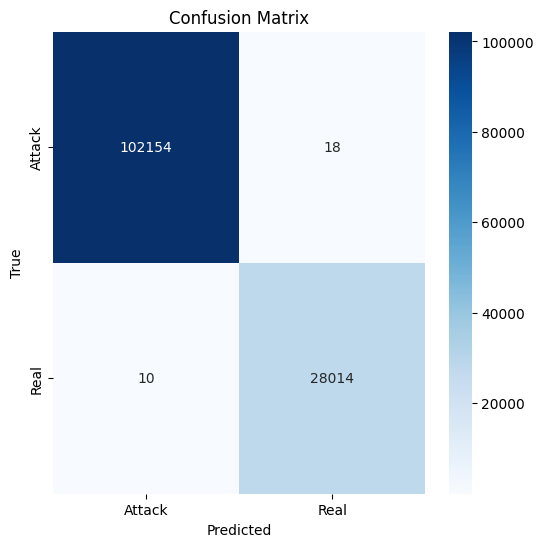


Visualizing predictions (Predicted vs Ground Truth):


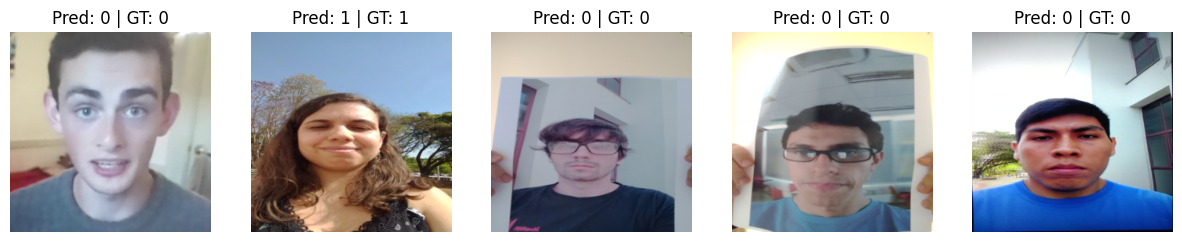

In [4]:
import torch
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Directory where the model is saved
save_path = '../models/trial91'
model_save_path = os.path.join(save_path, 'best_model.pth')

# Instantiate the model
model = SimpleResNetModel(pretrained=True).to(device)

# Load the best model weights
model.load_state_dict(torch.load(model_save_path, map_location=device))

# Set the model to evaluation mode
model.eval()

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Function to evaluate loader and visualize predictions
def evaluate_loader(loader, loader_name="Dataset", num_images_to_show=5):
    correct = 0
    total = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    eval_loss = 0.0

    all_preds = []
    all_labels = []
    
    images_to_visualize = []
    pred_labels_to_visualize = []
    gt_labels_to_visualize = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc=f"Evaluating {loader_name}"):
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)  # Ensure labels are [batch_size, 1]
            outputs = model(images)
            loss = criterion(outputs, labels)
            eval_loss += loss.item() * images.size(0)

            predictions = torch.round(torch.sigmoid(outputs))
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            # Store predictions and labels for confusion matrix
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Visualize some images
            if len(images_to_visualize) < num_images_to_show:
                images_to_visualize.extend(images.cpu()[:num_images_to_show - len(images_to_visualize)])
                pred_labels_to_visualize.extend(predictions.cpu()[:num_images_to_show - len(pred_labels_to_visualize)])
                gt_labels_to_visualize.extend(labels.cpu()[:num_images_to_show - len(gt_labels_to_visualize)])

            # Calculate true positives, true negatives, false positives, and false negatives
            for pred, label in zip(predictions, labels):
                if label == 1 and pred == 1:
                    true_positives += 1
                elif label == 1 and pred == 0:
                    false_negatives += 1
                elif label == 0 and pred == 1:
                    false_positives += 1
                else:
                    true_negatives += 1

    # Calculate metrics
    eval_loss /= total
    accuracy = correct / total

    # Calculate APCER, BPCER, ACER, HTER, and EER
    try:
        apcer = false_positives / (false_positives + true_negatives)
        bpcer = false_negatives / (false_negatives + true_positives)
        acer = (apcer + bpcer) / 2
        hter = (false_positives + false_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
        eer = bpcer  # Assuming the threshold is set to achieve EER
    except ZeroDivisionError:
        apcer, bpcer, acer, hter, eer = 0, 0, 0, 0, 0

    # Print out the results for the current loader
    print(f"\nResults for {loader_name}:")
    print(f"Loss: {eval_loss:.4f}, Accuracy: {accuracy:.4f}")
    print(f"APCER: {apcer:.4f}, BPCER: {bpcer:.4f}, ACER: {acer:.4f}, HTER: {hter:.4f}, EER: {eer:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Attack', 'Real']))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)
    plot_confusion_matrix(cm, class_names=['Attack', 'Real'])

    # Visualize a few images with predictions
    print("\nVisualizing predictions (Predicted vs Ground Truth):")
    fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 15))
    for idx, (img, pred_label, gt_label) in enumerate(zip(images_to_visualize, pred_labels_to_visualize, gt_labels_to_visualize)):
        img = img.permute(1, 2, 0).cpu().numpy()  # Change from (C, H, W) to (H, W, C) for plotting
        axes[idx].imshow(img)
        axes[idx].set_title(f"Pred: {int(pred_label.item())} | GT: {int(gt_label.item())}")
        axes[idx].axis('off')
    plt.show()

# Evaluate on all three loaders (training, validation, and test)

# 1. Evaluate on train_loader (Real vs Spoof for training set)
evaluate_loader(train_loader, loader_name="Training Set", num_images_to_show=5)



## val set eval

Evaluating Validation Set: 100%|████████████| 1018/1018 [33:28<00:00,  1.97s/it]



Results for Validation Set:
Loss: 0.0043, Accuracy: 0.9985
APCER: 0.0011, BPCER: 0.0028, ACER: 0.0020, HTER: 0.0015, EER: 0.0028

Classification Report:
              precision    recall  f1-score   support

      Attack       1.00      1.00      1.00     25472
        Real       1.00      1.00      1.00      7078

    accuracy                           1.00     32550
   macro avg       1.00      1.00      1.00     32550
weighted avg       1.00      1.00      1.00     32550

Confusion Matrix:
[[25444    28]
 [   20  7058]]


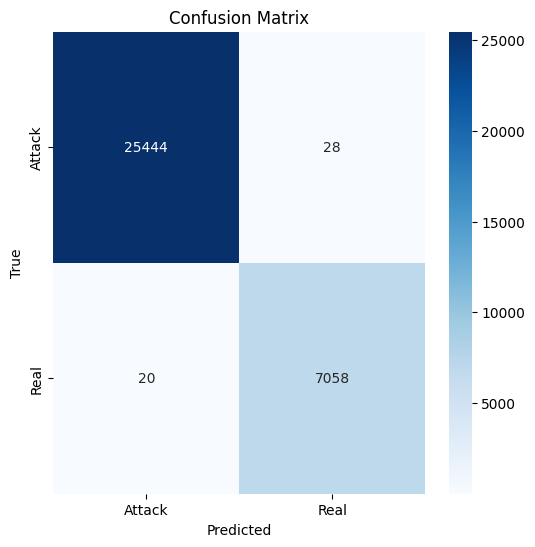


Visualizing predictions (Predicted vs Ground Truth):


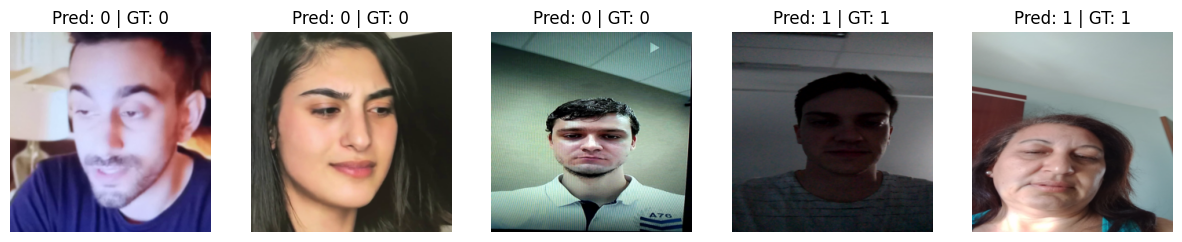

In [5]:
# 2. Evaluate on val_loader (Real vs Spoof for validation set)
evaluate_loader(val_loader, loader_name="Validation Set", num_images_to_show=5)




## Test set Eval (Cross dataset)

Evaluating Test Set: 100%|████████████████████| 915/915 [12:21<00:00,  1.23it/s]



Results for Test Set:
Loss: 2.1952, Accuracy: 0.6404
APCER: 0.0913, BPCER: 0.9694, ACER: 0.5303, HTER: 0.3596, EER: 0.9694

Classification Report:
              precision    recall  f1-score   support

      Attack       0.68      0.91      0.78     20324
        Real       0.13      0.03      0.05      8942

    accuracy                           0.64     29266
   macro avg       0.40      0.47      0.41     29266
weighted avg       0.51      0.64      0.56     29266

Confusion Matrix:
[[18468  1856]
 [ 8668   274]]


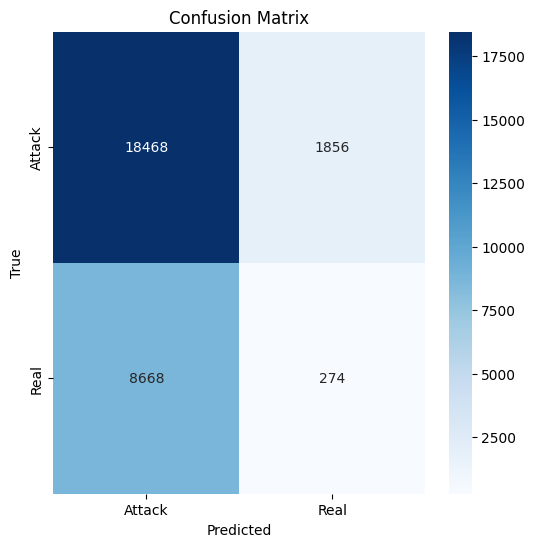


Visualizing predictions (Predicted vs Ground Truth):


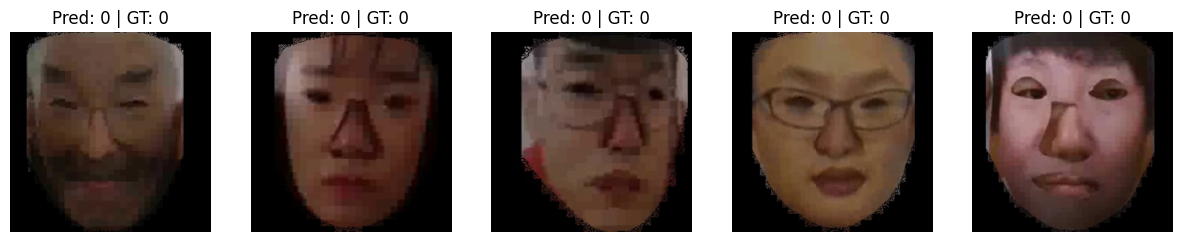

In [6]:
# 3. Evaluate on test_loader (Real vs Spoof for test set)
evaluate_loader(test_loader, loader_name="Test Set", num_images_to_show=5)